In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable

In [2]:
# 最简单的层次网络
class simpleNet(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim) :
        super().__init__()
        i, self.layer = 1, nn.Sequential()
        for h_dim in hidden_dim :
            self.layer.add_module('layer_{}'.format(i), nn.Linear(in_dim, h_dim))
            i, in_dim = i + 1, h_dim
        self.layer.add_module('layer_{}'.format(i), nn.Linear(in_dim, out_dim))
        self.layerNum = i
        
    def forward(self, x) :
        x = self.layer(x)
        return x

In [3]:
# 添加激活函数，增加网络的非线性

class Activation_Net(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim) :
        super().__init__()
        i, self.layer = 1, nn.Sequential()
        for h_dim in hidden_dim :
            self.layer.add_module('layer_{}'.format(i), nn.Sequential(nn.Linear(in_dim, h_dim), nn.ReLU(True)))
            i, in_dim = i + 1, h_dim
        self.layer.add_module('layer_{}'.format(i), nn.Sequential(nn.Linear(in_dim, out_dim)))
        self.layerNum = i
    def forward(self, x) :
        x = self.layer(x)
        return x

In [4]:
# 添加批标准化的网络

class Batch_net(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim) :
        super().__init__()
        i, self.layer = 1, nn.Sequential()
        for h_dim in hidden_dim :
            self.layer.add_module('layer_{}'.format(i), 
                                  nn.Sequential(nn.Linear(in_dim, h_dim), nn.BatchNorm1d(h_dim), nn.ReLU(True)))
            i, in_dim = i + 1, h_dim
        self.layer.add_module('layer_{}'.format(i), nn.Sequential(nn.Linear(in_dim, out_dim)))
        self.layerNum = i
    def forward(self, x) :
        x = self.layer(x)
        return x

In [5]:
# 确定超参数

epoch_size = 700
learning_rate = 1e-2
num_epoches = 60

---
这里本身自带手写数字的数据集，是从kaggle上下载的。给出[链接](https://www.kaggle.com/c/digit-recognizer/data)

保存为名为*/data* 的文件夹，文件结构如下 :
```
data
├── sample_submission.csv
├── test.csv
└── train.csv

0 directories, 3 files
```
---

In [6]:
# 获得训练数据 - train.csv

import csv
with open('./data/train.csv') as f :
    lines = csv.reader(f)
    label, attr = [], []
    for line in lines :
        if lines.line_num == 1 :
            continue
        label.append(int(line[0]))
        attr.append([float(j) for j in line[1:]])
print(len(label), len(attr[1]))

# 将数据分为 60(epoches) * 700(rows) 的数据集
epoches = []
for i in range(0, len(label), epoch_size) :
    torch_attr = torch.FloatTensor(attr[i : i + epoch_size])
    torch_label = torch.LongTensor(label[i : i + epoch_size])
    epoches.append((torch_attr, torch_label))

42000 784


In [7]:
# 模型实例化，Activation_Net,  
if torch.cuda.is_available() :
    net = Activation_Net(28 * 28, [300, 100], 10).cuda()
else :
    net = Activation_Net(28 * 28, [300, 100], 10)


In [8]:
# 损失函数
criterion = nn.CrossEntropyLoss()
# 优化函数
optimizer = optim.SGD(net.parameters(), lr = learning_rate)

In [9]:
# 训练过程
def train() :
    epoch_num, loss_sum, cort_num_sum = 0, 0.0, 0
    for epoch in epoches :
        epoch_num += 1
        if torch.cuda.is_available() :
            inputs = Variable(epoch[0]).cuda()
            target = Variable(epoch[1]).cuda()
        else :
            inputs = Variable(epoch[0])
            target = Variable(epoch[1])
        output = net(inputs)
        loss = criterion(output, target)
        # reset gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        
        # get training infomation
        loss_sum += loss.data[0]
        _, pred = torch.max(output.data, 1)
        
        #print(pred.shape)
        #print(epoch[1].shape)
        
        num_correct = torch.eq(pred, epoch[1]).sum()
        cort_num_sum += num_correct
        
    loss_avg = loss_sum / epoch_num
    cort_num_avg = cort_num_sum / epoch_num / epoch_size
    return loss_avg, cort_num_avg

# 对所有数据跑300遍模型
loss, correct = [], []
training_time = 300
for i in range(1, training_time + 1) :
    loss_avg, correct_num_avg = train()
    loss.append(loss_avg)
    if i< 20 or i % 20 == 0 :
        print('--- train time {} ---'.format(i))
        print('average loss = {:.4f}'.format(loss_avg))
        print('average correct number = {:.4f}'.format(correct_num_avg))
    correct.append(correct_num_avg)

--- train time 1 ---
average loss = 11.5832
average correct number = 0.4225
--- train time 2 ---
average loss = 0.5315
average correct number = 0.8423
--- train time 3 ---
average loss = 0.3385
average correct number = 0.8999
--- train time 4 ---
average loss = 0.2668
average correct number = 0.9208
--- train time 5 ---
average loss = 0.2259
average correct number = 0.9326
--- train time 6 ---
average loss = 0.2012
average correct number = 0.9394
--- train time 7 ---
average loss = 0.1813
average correct number = 0.9449
--- train time 8 ---
average loss = 0.1658
average correct number = 0.9500
--- train time 9 ---
average loss = 0.1531
average correct number = 0.9541
--- train time 10 ---
average loss = 0.1429
average correct number = 0.9567
--- train time 11 ---
average loss = 0.1339
average correct number = 0.9595
--- train time 12 ---
average loss = 0.1257
average correct number = 0.9615
--- train time 13 ---
average loss = 0.1180
average correct number = 0.9641
--- train time 14 --

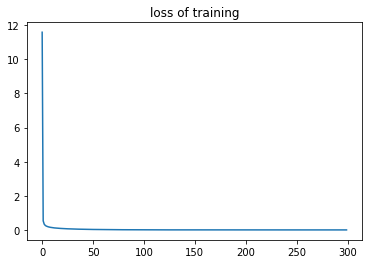

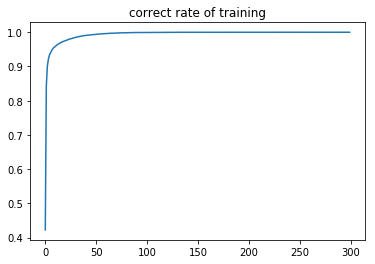

In [10]:
# 画图输出训练过程情况

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
# 画训练过程中的损失值图像
lx = np.array(range(len(loss)))
ly = np.array(loss)
plt.title('loss of training')
plt.plot(lx, ly)
plt.show()


# 画训练过程中正确率变化
cx = np.array(range(len(correct)))
cy = np.array(correct)
plt.title('correct rate of training')
plt.plot(cx, cy)
plt.show()

In [11]:
# 引入测试数据

with open('./data/test.csv') as f :
    lines = csv.reader(f)
    test = []
    for line in lines :
        if lines.line_num == 1 :
            continue
        test.append([float(i) for i in line])
test = torch.FloatTensor(test)
net.eval()
# volatile = True 表示前向传播不保留缓存
predict = net(Variable(test, volatile=True))
_, predict = torch.max(predict, 1)
predict = predict.data.numpy()

with open('./data/predict.csv', 'w') as f :
    writer = csv.writer(f)
    writer.writerow(['ImageId', 'Label'])
    for i in range(predict.shape[0]) :
        result = [i + 1, predict[i]]
        writer.writerow(result)
    print('write done.')

write done.
